In [580]:
#pip install nums_from_string
#pip install formulaic

In [581]:
#Primero importamos las librerías que vamos a utilizar en el trabajo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from formulaic import model_matrix
from sklearn.model_selection import GridSearchCV
import nums_from_string

#Procesamiento de datos


In [582]:
#Importamos el dataframe base para trabajar sobre el mismo
df = pd.read_csv('sube-2023.csv')

###Ejercicio 1 - A

In [583]:
print(df.dtypes) #Visualizamos los datos de data columna

df['DIA_TRANSPORTE'] = pd.to_datetime(df['DIA_TRANSPORTE']) #Transformamos la columna para que sea reconocida como fecha

DIA_TRANSPORTE     object
NOMBRE_EMPRESA     object
LINEA              object
AMBA               object
TIPO_TRANSPORTE    object
JURISDICCION       object
PROVINCIA          object
MUNICIPIO          object
CANTIDAD            int64
DATO_PRELIMINAR    object
dtype: object


###Ejercicio 1 - B
Creamos dos listas vacías, una para los días y otra para los meses, luego iteramos la columna 'DIA_TRANSPORTE' del dataframe y vamos agregando a estas listas los días y meses de cada fila correspondiente. Por último, creamos dos columnas nuevas con las listas construidas.

In [584]:
dias = []
mes = []

for row in df['DIA_TRANSPORTE']:

    num_dia = row.weekday()

    if num_dia == 0:
        dia = "Lunes"
    elif num_dia == 1:
        dia = "Martes"
    elif num_dia == 2:
        dia = "Miercoles"
    elif num_dia == 3:
        dia = "Jueves"
    elif num_dia == 4:
        dia = "Viernes"
    elif num_dia == 5:
        dia = "Sabado"
    elif num_dia == 6:
        dia = "Domingo"
    dias.append(dia)
    mes.append(row.month)

df['FECHA_DIA'] = dias
df['FECHA_MES'] = mes

Hacemos lo mismo para la fecha ordinal, creamos una lista vacía y luego iteramos con un for.

In [585]:
dia_ord = []
dias = df['DIA_TRANSPORTE'].dt.day
meses = df['DIA_TRANSPORTE'].dt.month

dias_por_mes = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

for i in range(0,len(dias),1):
    dia = dias[i]
    for n in range(1,meses[i],1):
        dia += dias_por_mes[n]
    dia_ord.append(dia)


df["FECHA_ORDINAL"] = dia_ord

df.head()

,DIA_TRANSPORTE,NOMBRE_EMPRESA,LINEA,AMBA,TIPO_TRANSPORTE,JURISDICCION,PROVINCIA,MUNICIPIO,CANTIDAD,DATO_PRELIMINAR,FECHA_DIA,FECHA_MES,FECHA_ORDINAL
0,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,1,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,61,NO,Domingo,1,1
1,2023-01-01,MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...,2B,SI,COLECTIVO,MUNICIPAL,BUENOS AIRES,MERCEDES,11,NO,Domingo,1,1
2,2023-01-01,EMPRESA BATAN S.A.,BS_AS_LINEA 715M,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1707,NO,Domingo,1,1
3,2023-01-01,COMPAÑIA DE TRANSPORTE VECINAL S.A.,BS_AS_LINEA_326,SI,COLECTIVO,PROVINCIAL,BUENOS AIRES,SN,438,NO,Domingo,1,1
4,2023-01-01,EMPRESA DE TRANSPORTE PERALTA RAMOS SACI,BS_AS_LINEA_512,NO,COLECTIVO,MUNICIPAL,BUENOS AIRES,GENERAL PUEYRREDON,1189,NO,Domingo,1,1


###Ejercicio 2
Primero filtramos el Dataframe por la columna de Datos Preliminares y luego nos quedamos con el mismo dataframe, pero con las columnas que nos interesan y con el orden correspondiente.

Luego con un for y un diccionario vacío ponemos los nombres de las columnas en minúsculas, los casos en los que hay que cambiarle el nombre a la columna los modificamos al final del for.

In [586]:
#Filtrado de Dataframe y columnas
df = df[(df['DATO_PRELIMINAR'] == "NO")]
df = df[['DIA_TRANSPORTE','FECHA_DIA','FECHA_MES', 'FECHA_ORDINAL','JURISDICCION','AMBA','LINEA','CANTIDAD','TIPO_TRANSPORTE']]


columnas = {} #Diccionario vacío
for columns in df.columns:
    columnas[columns] = columns.lower()

#Cambiamos los valores para las siguientes claves
columnas['DIA_TRANSPORTE'] = 'fecha'
columnas['CANTIDAD'] = 'pasajeros'
columnas['AMBA'] = 'amba'

#Renombramos las columnas pasando el diccionario anterior
df = df.rename(columns=columnas)

#Por último nos quedamos con los datos de amba y eliminamos la columna
datos_amba = df[(df['amba'] == "SI")]
datos_amba = datos_amba.drop('amba', axis=1)
datos_amba.head()

,fecha,fecha_dia,fecha_mes,fecha_ordinal,jurisdiccion,linea,pasajeros,tipo_transporte
0,2023-01-01,Domingo,1,1,MUNICIPAL,1,61,COLECTIVO
1,2023-01-01,Domingo,1,1,MUNICIPAL,2B,11,COLECTIVO
3,2023-01-01,Domingo,1,1,PROVINCIAL,BS_AS_LINEA_326,438,COLECTIVO
5,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_514,3067,COLECTIVO
6,2023-01-01,Domingo,1,1,MUNICIPAL,BS_AS_LINEA_522,332,COLECTIVO


###Ejercicio 3

In [587]:
#Ejercicio 3 - A

proporcion = (datos_amba.groupby('tipo_transporte')['pasajeros'].sum()) / (datos_amba['pasajeros'].sum()) *100
proporcion

tipo_transporte
COLECTIVO    83.764488
SUBTE         6.809700
TREN          9.425812
Name: pasajeros, dtype: float64

In [588]:
#Ejercicio 3 - B

#Filtramos el dataframe por tipo de transporte
datos_amba_subte = datos_amba[datos_amba['tipo_transporte'] == "SUBTE"]

#Agrupamos los datos por ambas columnas
mes_max_pasajeros = datos_amba_subte.groupby(["fecha_mes","linea"])['pasajeros'].sum()

#Nos quedamos con el dato que nos interesa
tupla = (mes_max_pasajeros.idxmax())

tupla

(8, 'LINEA_B')

In [589]:
#Ejercicio 3 - C

#Filtramos el dataframe por días hábiles
datos_amba_dias_habiles = datos_amba[(datos_amba['fecha_dia'] != "Sabado") & (datos_amba['fecha_dia'] != "Domingo")]

#Agrupamos los datos y nos quedamos con el dato que nos interesa
dia_habil_menor_std = datos_amba_dias_habiles.groupby('fecha_dia')['pasajeros'].std().idxmin()

dia_habil_menor_std


'Lunes'

#Análisis Exploratorio


El objetivo nuestro en este punto del TP es comparar el uso del transporte público durante el año con respecto a los meses de enero y febrero. Los cuales son meses de vacaciones tanto para personas que trabajan como para gente que estudia, ya sea nivel primario/secundario/universitario. Si bien en diciembre y marzo tambien suele haber vacaciones, no tomamos estos meses porque no suelen ser meses de vacaciones "completos" para todos, para simplificar lo que queremos ver utilizamos los meses de enero y febrero.

Algunas de las preguntas que nos realizamos para realizar dicho estudio son: Se viaja mas en transporte publico durante el año que en enero y febrero? En caso de que esto sea asi, cuanto mas o cuanto menos se viaja en promedio? Ocurre lo mismo en AMBA que en el resto del pais? Existen casos de linea de colectivos que esto no aplique?

Vamos a tener dos graficos, uno para comparar lo sucedido en el AMBA y otro con el resto del pais.

Primero vamos a crear sobre el dataframe "df" una columna de referencia para que los graficos queden mas prolijos y no cometer errores luego con las fechas.

In [590]:
referencia = []

for row in df['fecha_mes']:

    if (row == 1) | (row == 2):
        referencia.append("Enero - Febrero")
    else:
        referencia.append("Resto del Año")


df['referencia'] = referencia



Luego utilizando un "for", el cual se ejecutara solo dos veces, filtramos el dataframe segun es necesario. Utilizamos para caso de "amba" una instancia del for diferente. Luego en cada grafico podemos ver la compararacion de "Enero - Febrero" contra "Resto del Año"

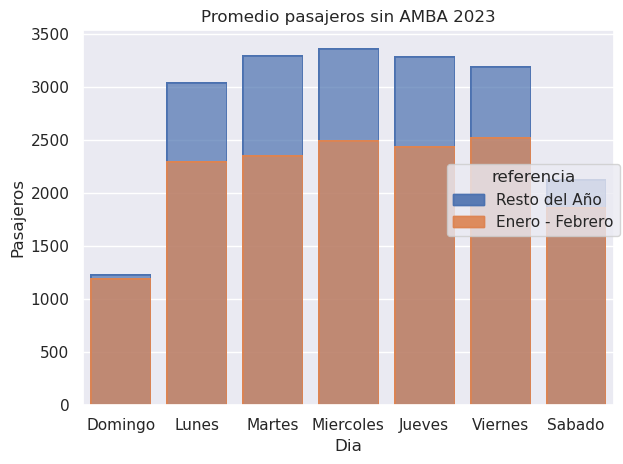

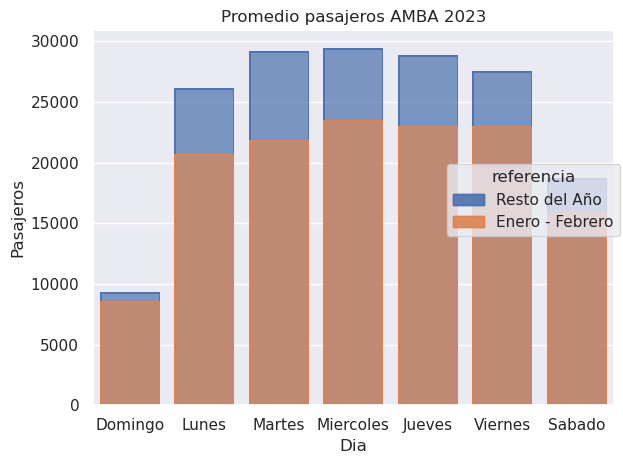

In [591]:

for i in range(0,2,1):

    if i == 1:
        titulo = "Promedio pasajeros AMBA 2023"
        amba = "SI"
    else:
        titulo = "Promedio pasajeros sin AMBA 2023"
        amba = "NO"

    (
        so.Plot(data = df, x = "fecha_dia", y = "pasajeros")
        .add(so.Bar(), so.Agg("mean"), data = df[(df['amba'] == amba) & (df['referencia'] == "Resto del Año")], color = "referencia")
        .add(so.Bar(), so.Agg("mean"), data = df[(df['amba'] == amba) & (df['referencia'] == "Enero - Febrero")], color = "referencia")

        .label(

            title=titulo,
            x="Dia",
            y="Pasajeros",
           color = "referencia",
        )



    ).show()

Una vez terminados los graficos vamos a ver un poco mas en profundidad, si bien se ve claramente que el promedio de uso de transporte publico en el AMBA es considerablemente mayor que al del resto del pais, el objetivo aca es ver que el aumento de la proporcion de uso en "Enero - Febrero" con respecto a "Resto del año" es bastante similar en ambos casos. Creamos unas medidas para poder ver estos datos de forma mas exacta

In [592]:
#Dataframe sin Amba, Sin enero y Sin febrero
df_no_amba_sin_en_feb = df[(df['amba'] == "NO") & (df['referencia'] == "Resto del Año")].groupby("fecha_dia")['pasajeros'].mean()

#Dataframe sin Amba, Resto del Año
df_no_amba_en_feb = df[(df['amba'] == "NO") & (df['referencia'] == "Enero - Febrero")].groupby("fecha_dia")['pasajeros'].mean()

aumento_proporcion = df_no_amba_sin_en_feb - df_no_amba_en_feb

aumento_proporcion = (aumento_proporcion * 100) / df_no_amba_sin_en_feb

print(aumento_proporcion)

fecha_dia
Domingo       2.465413
Jueves       25.857096
Lunes        24.537610
Martes       28.427237
Miercoles    25.635739
Sabado       12.196519
Viernes      20.881035
Name: pasajeros, dtype: float64


In [593]:
#Dataframe Amba, Sin enero y Sin febrero
df_amba_sin_en_feb = df[(df['amba'] == "SI") & (df['referencia'] == "Resto del Año")].groupby("fecha_dia")['pasajeros'].mean()

#Dataframe Amba, Resto del Año
df_amba_en_feb = df[(df['amba'] == "SI") & (df['referencia'] == "Enero - Febrero")].groupby("fecha_dia")['pasajeros'].mean()


aumento_proporcion = df_amba_sin_en_feb - df_amba_en_feb

aumento_proporcion = (aumento_proporcion * 100) / df_amba_sin_en_feb

print(aumento_proporcion)

fecha_dia
Domingo       8.545820
Jueves       20.150120
Lunes        20.689070
Martes       25.212471
Miercoles    20.060801
Sabado       15.203464
Viernes      16.600822
Name: pasajeros, dtype: float64


Podemos ver como en ambos casos se da un aumento del uso de transporte publico en epocas que no hay vacaciones, ademas tambien podemos ver que los viernes son dias donde se viaje menos en transporte publico y los martes suele ser el dia que mas se utiliza el transporte publico, tanto para AMBA como para el resto del pais

# MODELADO

La idea del apartado de modelado es resolver el ejercicio cinco del TP1. Se realizaran tres modelos para aproximar la cantidad de usuarios por dia de la linea nueve. A medida que se avance con cada modelo se ira analizando cada uno, y tambien se realizara una comparación final entre los tres modelos para decidir uno final.

## Ejercicio 5.a

In [594]:
datos = pd.read_csv("sube-2023-regresion.csv")

In [595]:
colectivos = datos[(datos["TIPO_TRANSPORTE"] == "COLECTIVO") & (datos["PROVINCIA"] == "JN")
                   & (datos["AMBA"] == "SI")  & (datos["DATO_PRELIMINAR"] == "NO")]

columnas = colectivos["LINEA"].unique()

pasajeros = pd.DataFrame()

for columna in columnas:
    linea = colectivos[colectivos["LINEA"] == columna][["DIA_TRANSPORTE", "CANTIDAD"]]
    linea = linea.set_index("DIA_TRANSPORTE").rename(columns = {"CANTIDAD" : columna})
    pasajeros = pd.concat([pasajeros, linea], axis = 1)

In [596]:
#Cantidad de columnas que quedan sin datos nulos
#print(len(pasajeros.columns)-(pasajeros.isnull().sum()/pasajeros.isnull().sum()).sum())

## Ejercicio 5.b

In [597]:
#for columna in pasajeros.columns:
    #if pasajeros[columna].isnull().sum() != 0:
        #pasajeros = pasajeros.drop(columna, axis = 1)

#Use esta funcion hasta que me di cuenta que podia usar dropna con axis = 1 :D

In [598]:
pasajeros = pasajeros.dropna(axis = 1)

#pasajeros.isnull().sum().sum() == 0
#Con esto chequea que no tenga ningun null, el primer sum lo hace por linea, el segundo entre todas las lineas

## Ejercicio 5.c

In [599]:
#Para facilitar lectura y obtencion de distintos datos se va a usar el paquete nums_from_string, para poder asignar a cada linea de colectivo unicamente L + su numero, como identificador de la columna

columnas_nums = []

for i in pasajeros.columns:
    num = nums_from_string.get_nums(i)
    columnas_nums += num

columnas_nums = ['L'+str(n) for n in columnas_nums]

pasajeros.columns = columnas_nums

#Chequear que queden los numeros y cada columna pasada como string
#pasajeros
#type(pasajeros.columns[0])

## Modelo 1

La idea para armar el primer modelo fue averiguar las terminales de la linea nueve (que son Retiro y Villa Caraza) y encontrar lineas de colectivos que pasen por la zona. La hipotesis es que las paradas que son mas cercanas a las terminales suelen tener mas poblacion de pasajeros que las intermedias. Por lo tanto para un primer modelo se aproximara por lineas que tengan paradas cercanas a las de las terminales de la linea nueve.

RETIRO:
5, 6, 7, 9, 20, 21, 22, 23, 26, 33, 45, 50, 51, 54, 56, 61, 62, 70, 75, 91, 100,
101, 106, 108, 115, 126, 129, 130, 132, 143, 150, 152 y 195

VILLA CARAZA:
9, 158, 247 y 520

Con estas lineas la idea es averiguar cuales son las que mueven mas pasajeros, y tambien cuales son las de mayor correlacion con la linea nueve. Se elegiran para el primer modelo las primeras cinco lineas que aparezcan en ambas listas en simultaneo.

In [600]:
retiro = [5, 6, 7, 20, 21, 22, 23, 26, 28, 33, 45, 50, 51, 54, 56, 61, 62, 70, 75, 91, 100,
101, 106, 108, 115, 126, 129, 130, 132, 143, 150, 152, 195]

lineas_retiro = ['L'+str(x) for x in retiro if 'L'+str(x) in pasajeros.columns]

villa_caraza = [158, 247, 520]

lineas_villa_caraza = ['L'+str(x) for x in villa_caraza if 'L'+str(x) in pasajeros.columns]

In [601]:
ret_vil = ['L9'] + lineas_retiro + lineas_villa_caraza
pasajeros_ret_vil = pasajeros[ret_vil]
#pasajeros_ret_vil.head()

In [602]:
mas_corr = []
copia = pasajeros_ret_vil.corr()[['L9']].copy()
copia = copia.drop(index = 'L9', axis = 1)

for i in range(0,12,1):
    a = copia.idxmax().iloc[0]
    copia = copia.drop(index = a, axis = 1)
    mas_corr.append(a)

mas_corr
#Las 12 lineas que mas correlacion tienen con la linea 9

['L101',
 'L7',
 'L150',
 'L100',
 'L115',
 'L106',
 'L6',
 'L91',
 'L56',
 'L50',
 'L28',
 'L108']

In [603]:
mas_pas = []
copia = pasajeros_ret_vil.copy()
copia = copia.drop('L9', axis = 1)

for i in range(0,12,1):
    a = copia.sum().idxmax()
    copia = copia.drop(a, axis = 1)
    mas_pas.append(a)

mas_pas
#Las 12 lineas que mas gente mueven y pasan por Retiro o Villa Caraza

['L28',
 'L152',
 'L21',
 'L132',
 'L130',
 'L33',
 'L101',
 'L126',
 'L106',
 'L100',
 'L45',
 'L91']

In [604]:
mejores = list(set(mas_corr) & set(mas_pas))
mejores

['L28', 'L106', 'L101', 'L100', 'L91']

Se encontro que entre las doce primeras lineas con mayor correlacion y con mayor cantidad de pasajeros coinciden 5 lineas, por lo tanto seria interesante utilizar estas para armar un modelo.

Como se dijo anteriormente, se utilizara un modelo de Regresion Ridge, con un GridSearchCV para encontrar un alpha optimo.

Se separaran los datos en entramiento y testeo, los primeros se usaran para ajustar los hiperparametros y parametros del modelo, y los segundos para chequear al modelo.

In [787]:
X, y = pasajeros[pasajeros.drop('L9', axis = 1).columns], pasajeros[['L9']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1)

In [788]:
formula = ' ~ L28 + L106 + L101 + L100 + L91'
X1_train = model_matrix(formula, X_train)
X1_test = model_matrix(formula, X_test)

In [789]:
alpha = {"alpha": np.logspace(-7,7,100)}

gs = GridSearchCV(Ridge(fit_intercept = False), alpha, cv = 5, scoring = "neg_root_mean_squared_error", return_train_score = True)
gs.fit(X1_train, y_train)

print("MODELO 1")
print("Mejor alpha:", round(gs.best_params_['alpha'], 5))
print("Mejor error:", round(gs.best_score_, 3))

MODELO 1
Mejor alpha: 4.32876
Mejor error: -1997.096


In [790]:
cv1 = pd.DataFrame(gs.cv_results_)[["param_alpha", "mean_test_score", "mean_train_score"]]
cv1[["mean_test_score", "mean_train_score"]] *= -1
#cv1

Visualizacion de errores de entrenamiento y validacion para cada alpha, dentro de la busqueda de GridSearchCV

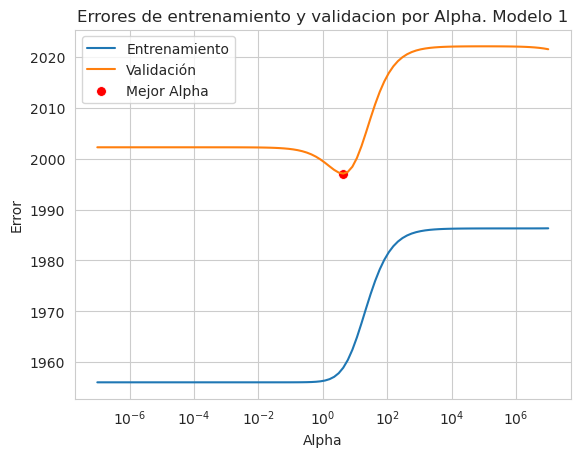

In [791]:
sns.lineplot(x = "param_alpha", y = "mean_train_score", data = cv1, label = "Entrenamiento")
sns.lineplot(x = "param_alpha", y = "mean_test_score", data = cv1, label = "Validación")
sns.scatterplot(x = gs.best_params_, y = -1*gs.best_score_, color = 'red', s = 50, label = "Mejor Alpha")
plt.xscale("log")
plt.ylabel("Error")
plt.xlabel("Alpha")
plt.title("Errores de entrenamiento y validacion por Alpha. Modelo 1")
plt.show()

Veamos los errores y R cuadrado dentro de los datos de testeo que separamos. Tambien hagamos un poco de analisis de que pasa con los residuos y con los datos reales respecto de los predichos por el modelo

In [792]:
y1_pred = gs.predict(X1_test)

r2 = r2_score(y_test, y1_pred)
recm = np.sqrt(mean_squared_error(y_test, y1_pred))

print("MODELO 1")
print('El R cuadrado del modelo:', round(r2, 3))
print('La raiz del error cuadratico medio del modelo:', round(recm, 3))

MODELO 1
El R cuadrado del modelo: 0.971
La raiz del error cuadratico medio del modelo: 1776.885


In [793]:
test = X1_test.copy()
test["y_test"] = y_test
test["y_pred"] = y1_pred
test["Residuos"] = y_test - y1_pred

In [794]:
residuo_medio = np.sqrt(test["Residuos"]**2).mean()
test_mean = test["y_test"].mean()
pred_mean = test["y_pred"].mean()
print("MODELO 1")
print("El promedio de los datos de test es:", test_mean)
print("El promedio de los datos de prediccion es:", round(pred_mean, 2))
print("La diferencia entre los promedios es de:", round(pred_mean - test_mean, 2))
print("El promedio de los residuos es de:", round(residuo_medio, 2))

MODELO 1
El promedio de los datos de test es: 24181.84
El promedio de los datos de prediccion es: 24134.9
La diferencia entre los promedios es de: -46.94
El promedio de los residuos es de: 1306.08


Se cree que la "gran" diferencia entre el promedio de los residuos y la diferencia de los promedio de datos de test y de predicción se deben a outliers o a una "distribucion alargada" en los datos de la linea nueve, hay dias donde los pasajeros son muy bajos o altos comparados a la media. Lo dicho se puede observar en el siguiente plot, como se mueve de manera "poco normal" hacia la izquierda la distribucion y hay muchisimos datos en la zona entre 35000 y 40000, cuando la media esta en 24181.

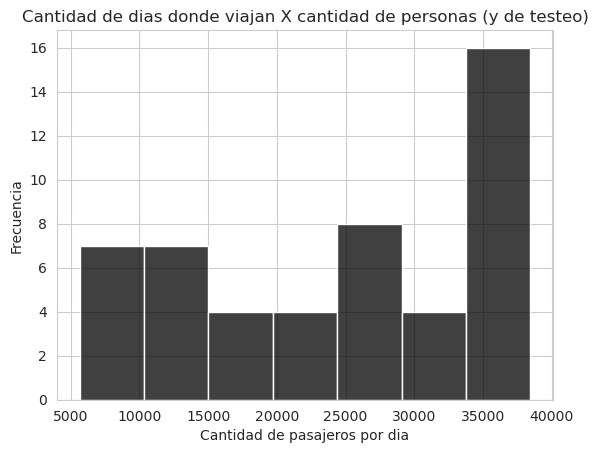

In [795]:
sns.set_style("whitegrid")
sns.histplot(data = y_test, x = 'L9', color = 'black')
plt.xlabel("Cantidad de pasajeros por dia")
plt.ylabel("Frecuencia")
plt.title("Cantidad de dias donde viajan X cantidad de personas (y de testeo)")
None

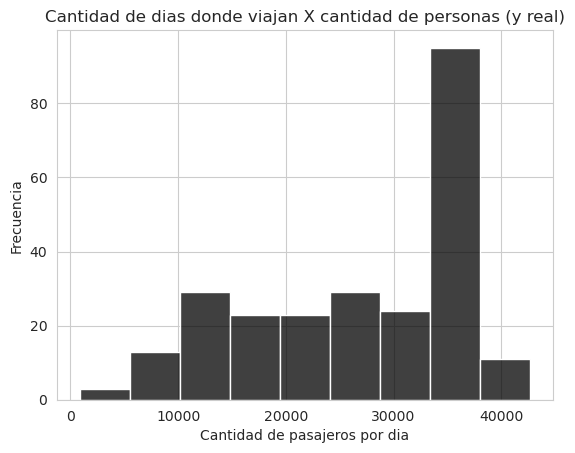

In [796]:
sns.set_style("whitegrid")
sns.histplot(data = y, x = 'L9', color = 'black')
plt.xlabel("Cantidad de pasajeros por dia")
plt.ylabel("Frecuencia")
plt.title("Cantidad de dias donde viajan X cantidad de personas (y real)")
None

El modelo aproxima muy bien los datos cercanos a la media, por eso "falla" en los casos donde los datos se alejan de esta misma, pero las medias de los datos y de las predicciones son muy parecidas. En los siguientes casos se puede ver como datos que se encuentrar en un rango mas cercano a la media hacen mejorar mucho la media de los residuos.

In [797]:
y_sinout = test["y_test"][(20000 < test["y_test"]) & (test["y_test"] < 30000)]
y_pred_sinout = test["y_pred"][(20000 < test["y_test"]) & (test["y_test"] < 30000)]
res_sinout = y_sinout - y_pred_sinout
print('En el rango de 20000 a 30000 pasajeros por dias el promedio de los residuos es:', round((np.sqrt(res_sinout**2)).mean(),2))

En el rango de 20000 a 30000 pasajeros por dias el promedio de los residuos es: 1062.07


In [798]:
y_sinout = test["y_test"][(22000 < test["y_test"]) & (test["y_test"] < 26000)]
y_pred_sinout = test["y_pred"][(22000 < test["y_test"]) & (test["y_test"] < 26000)]
res_sinout = y_sinout - y_pred_sinout
print('En el rango de 22000 a 26000 pasajeros por dias el promedio de los residuos es:', round((np.sqrt(res_sinout**2)).mean(),2))

En el rango de 22000 a 26000 pasajeros por dias el promedio de los residuos es: 456.19


Pequeo analisis de los residuos en funcion de las variables predictoras

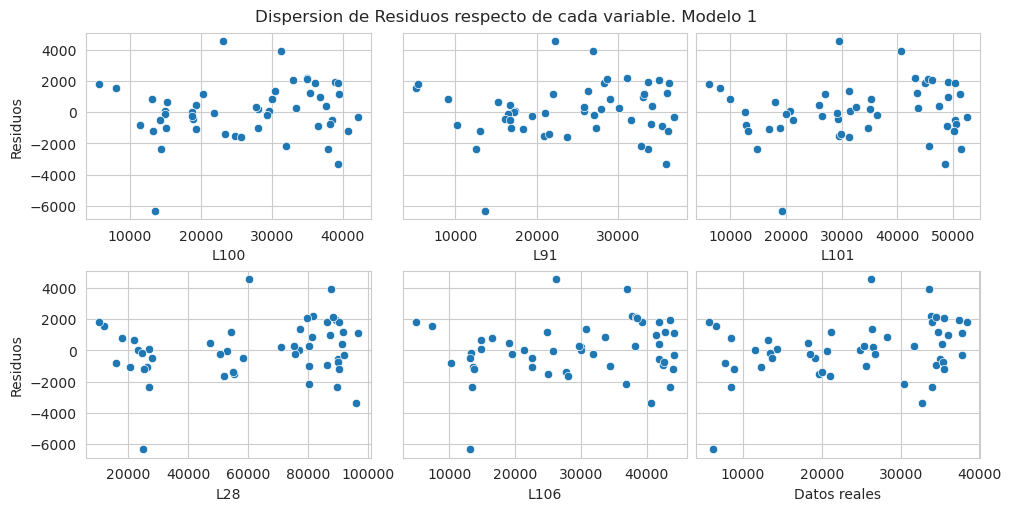

In [799]:
fig, axs = plt.subplots(2, 3, figsize = (10, 5), sharey = True, layout='constrained')

for versus, ax in zip(['L100', 'L91', 'L101', 'L28', 'L106', 'y_test'], axs.flatten()):
    sns.scatterplot(data = test, x = versus, y = "Residuos", ax = ax)

fig.suptitle("Dispersion de Residuos respecto de cada variable. Modelo 1")
axs[1,2].set_xlabel("Datos reales")
None

Ademas se puede ver que no hay estructura de los residuos alrededor de ninguna variable predictora, por lo tanto todo esto en conjunto nos da un modelo bastante consistente, con errores bajos (particularmente cerca la media) y una dependencia logica de las variables.

## Modelo 2

La idea del segundo modelo es utilizar los datos de colectivos que pasan por el Metrobus de 9 de Julio, donde la linea nueve realiza gran parte de su recorrido. Esta idea se inspira en que el Metrobus 9 de Julio tiene aproximadamente 255 mil pasajeros diaros entre los distintos colectivos que lo recorren, siendo de los mas demandados de la red de Metrobus.

https://buenosaires.gob.ar/infraestructura/movilidad/metrobus/red-de-metrobus

Colectivos Metrobus 9 de Julio:
9, 10, 17, 39, 45, 59, 67, 70, 91, 98, 100, 129

A nivel modelo/analisis se utilizaran las mismas herramientas que para el anterior modelo, aprovechando el GridSearchCV y distintos analisis relacionados con errores y residuos.

In [800]:
metrobus = [10, 17, 39, 45, 59, 67, 70, 91, 98, 100, 129]

lineas_metrobus = ['L'+str(x) for x in metrobus if 'L'+str(x) in pasajeros.columns]

In [801]:
metr = ['L9'] + lineas_metrobus

pasajeros_metr = pasajeros[metr]

Busco las primeras 5 lineas que coincidan en correlación con la linea nueve y con mayor cantidad de pasajeros

In [802]:
mas_corr = []
copia = pasajeros_metr.corr()[['L9']].copy()
copia = copia.drop(index = 'L9', axis = 1)

for i in range(0,7,1):
    a = copia.idxmax().iloc[0]
    copia = copia.drop(index = a, axis = 1)
    mas_corr.append(a)

mas_corr
#Las 7 lineas con mas correlacion con la linea nueve que pasan por el metrobus

['L100', 'L91', 'L67', 'L98', 'L17', 'L10', 'L59']

In [803]:
mas_pas = []
copia = pasajeros_metr.copy()
copia = copia.drop('L9', axis = 1)

for i in range(0,7,1):
    a = copia.sum().idxmax()
    copia = copia.drop(a, axis = 1)
    mas_pas.append(a)

mas_pas
#Las 7 lineas con mas pasajeros con la linea nueve que pasan por el metrobus

['L59', 'L98', 'L39', 'L17', 'L67', 'L100', 'L45']

In [804]:
mejores = list(set(mas_corr) & set(mas_pas))
mejores

['L98', 'L59', 'L100', 'L67', 'L17']

Entre las primeras siete lineas con mas pasajeros y mas correlación con la linea nueve hay cinco que coinciden.

In [805]:
formula2 = ' ~ L100 + L59 + L98 + L17 + L67'
X2_train = model_matrix(formula2, X_train)
X2_test = model_matrix(formula2, X_test)

In [806]:
gs2 = GridSearchCV(Ridge(fit_intercept = False), alpha, cv = 5, scoring = "neg_root_mean_squared_error", return_train_score = True)
gs2.fit(X2_train, y_train)

print("MODELO 2")
print("Mejor alpha:", round(gs2.best_params_['alpha'], 5))
print("Mejor error:", round(gs2.best_score_, 3))

MODELO 2
Mejor alpha: 1.62975
Mejor error: -2528.501


In [807]:
cv2 = pd.DataFrame(gs2.cv_results_)[["param_alpha", "mean_test_score", "mean_train_score"]]
cv2[["mean_test_score", "mean_train_score"]] *= -1
#cv2

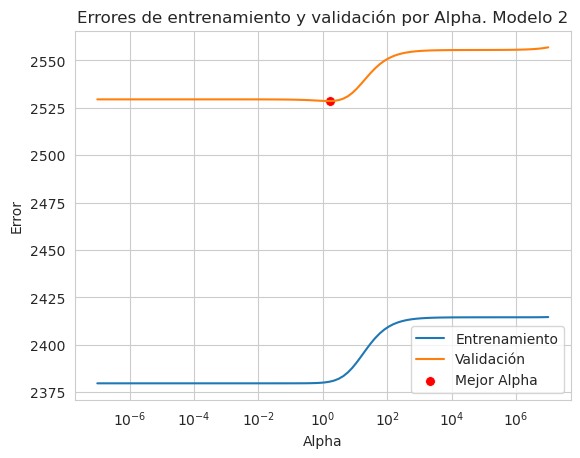

In [808]:
sns.lineplot(x = "param_alpha", y = "mean_train_score", data = cv2, label = "Entrenamiento")
sns.lineplot(x = "param_alpha", y = "mean_test_score", data = cv2, label = "Validación")
sns.scatterplot(x = gs2.best_params_, y = -1*gs2.best_score_, color = 'red', s = 50, label = "Mejor Alpha")
plt.xscale("log")
plt.ylabel("Error")
plt.xlabel("Alpha")
plt.title("Errores de entrenamiento y validación por Alpha. Modelo 2")
plt.show()

In [809]:
y2_pred = gs2.predict(X2_test)

r2_2 = r2_score(y_test, y2_pred)
recm_2 = np.sqrt(mean_squared_error(y_test, y2_pred))

print("MODELO 2")
print('El R cuadrado del modelo dio:', round(r2_2, 3))
print('La raiz del error cuadratico medio del modelo dio:', round(recm_2, 3))

MODELO 2
El R cuadrado del modelo dio: 0.947
La raiz del error cuadratico medio del modelo dio: 2404.49


A partir de este punto se puede ver que este segundo modelo ya tiene un error mayor al primer modelo y un peor R cuadrado, el analisis que se realiza de este modelo es complementario, pero no tan especifico como fue el del primer modelo, ya que queda descartado contra este mismo.

In [810]:
test2 = X2_test.copy()
test2["y_test"] = y_test
test2["y_pred"] = y2_pred
test2["Residuos"] = y_test - y2_pred

In [811]:
residuo2_medio = np.sqrt(test2["Residuos"]**2).mean()
test2_mean = test2["y_test"].mean()
pred2_mean = test2["y_pred"].mean()
print("MODELO 2")
print("El promedio de los datos de test es:", test2_mean)
print("El promedio de los datos de prediccion es:", round(pred2_mean, 2))
print("La diferencia entre los promedios es de:", round(pred2_mean - test2_mean, 2))
print("El promedio de los residuos es de:", round(residuo2_medio, 2))

MODELO 2
El promedio de los datos de test es: 24181.84
El promedio de los datos de prediccion es: 24384.54
La diferencia entre los promedios es de: 202.7
El promedio de los residuos es de: 1875.73


Tambien se puede ver como empeora la diferencia entre los promedios y los residuos respecto del modelo anterior.

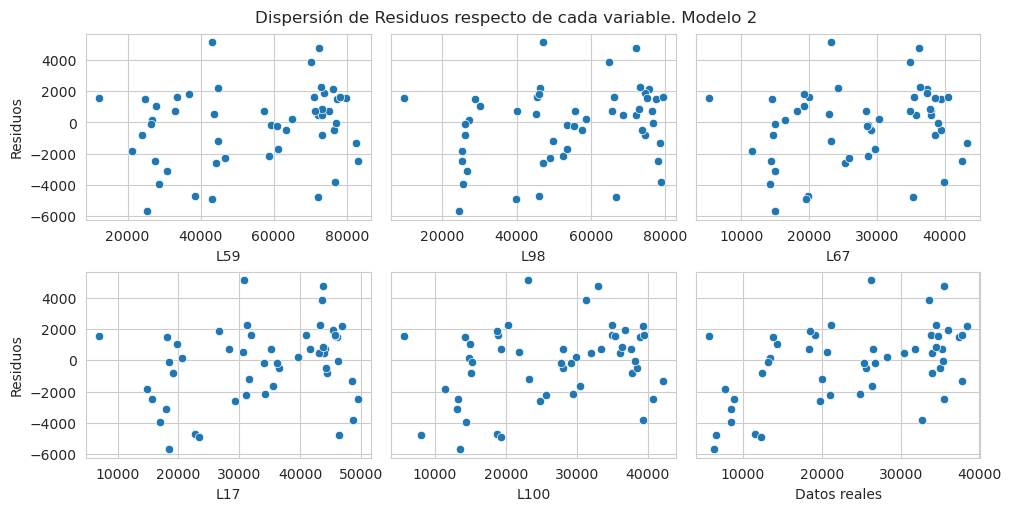

In [812]:
fig, axs = plt.subplots(2, 3, figsize = (10, 5), sharey = True, layout='constrained')

for versus, ax in zip(['L59', 'L98', 'L67', 'L17', 'L100', 'y_test'], axs.flatten()):
    sns.scatterplot(x = versus, y = "Residuos", data = test2, ax = ax)

fig.suptitle("Dispersión de Residuos respecto de cada variable. Modelo 2")
axs[1,2].set_xlabel("Datos reales")
None

Para ver que de cualquier manera si este modelo es valido o si se puede mejorar, se realizo un grafico de dispersión de los residuos, pero no parece haber estructura alrededor de ninguna variable.

## Modelo 3

Para el ultimo modelo se utilizara en todo el dataset la correlacion con la linea 9. Hasta ahora se utilizaron modelos muy especificos, la idea era comparar los modelos especificos con un modelo mas general, para ver si hipotesis particular podria ser mejor que un modelo solo teniendo en cuenta los datos.

In [813]:
copia = pasajeros.corr()["L9"].copy()
copia = copia.drop("L9")
mejores_coef = []
for i in range(0,5,1):
    a = copia.idxmax()
    mejores_coef.append(a)
    copia = copia.drop(index = a, axis = 1)

mejores_coef

['L101', 'L146', 'L7', 'L24', 'L107']

In [814]:
formula3 = ' ~ L101 + L146 + L7 + L24 + L107'
X3_train = model_matrix(formula3, X_train)
X3_test = model_matrix(formula3, X_test)

In [834]:
gs3 = GridSearchCV(Ridge(fit_intercept = False), alpha, cv = 5, scoring = "neg_root_mean_squared_error", return_train_score = True)
gs3.fit(X3_train, y_train)

print("MODELO 3")
print("Mejor alpha:", round(gs3.best_params_['alpha'], 5))
print("Mejor error:", round(gs3.best_score_, 3))

MODELO 3
Mejor alpha: 10000000.0
Mejor error: -1998.41


In [816]:
cv3 = pd.DataFrame(gs3.cv_results_)[["param_alpha", "mean_test_score", "mean_train_score"]]
cv3[["mean_test_score", "mean_train_score"]] *= -1
#cv3

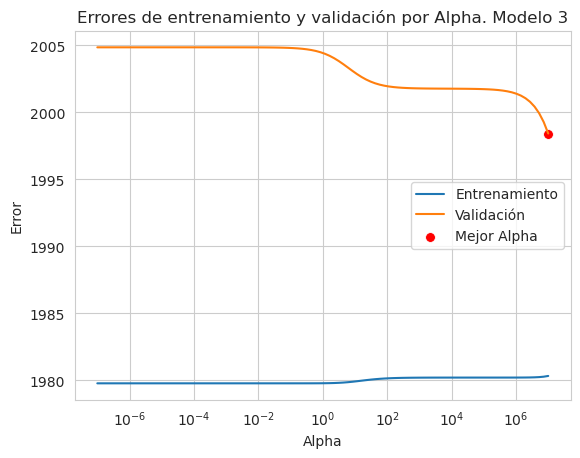

In [817]:
sns.lineplot(x = "param_alpha", y = "mean_train_score", data = cv3, label = "Entrenamiento")
sns.lineplot(x = "param_alpha", y = "mean_test_score", data = cv3, label = "Validación")
sns.scatterplot(x = gs3.best_params_, y = -1*gs3.best_score_, color = 'red', s = 50, label = "Mejor Alpha")
plt.xscale("log")
plt.ylabel("Error")
plt.xlabel("Alpha")
plt.title("Errores de entrenamiento y validación por Alpha. Modelo 3")
plt.show()

In [818]:
y3_pred = gs3.predict(X3_test)

r2_3 = r2_score(y_test, y3_pred)
recm_3 = np.sqrt(mean_squared_error(y_test, y3_pred))
print("MODELO 3")
print('El R cuadrado del modelo dio:', round(r2_3, 3))
print('La raiz del error cuadratico medio del modelo dio:', round(recm_3, 3))

MODELO 3
El R cuadrado del modelo dio: 0.969
La raiz del error cuadratico medio del modelo dio: 1849.925


Tanto el R cuadrado como la raiz del error cuadratico medio son muy parecidos a los del primer modelo

In [819]:
test3 = X3_test.copy()
test3["y_test"] = y_test
test3["y_pred"] = y3_pred
test3["Residuos"] = y_test - y3_pred

In [820]:
residuo3_medio = np.sqrt(test3["Residuos"]**2).mean()
test3_mean = test3["y_test"].mean()
pred3_mean = test3["y_pred"].mean()
print("MODELO 3")
print("El promedio de los datos de test es:", test3_mean)
print("El promedio de los datos de prediccion es:", round(pred3_mean, 2))
print("La diferencia entre los promedios es de:", round(pred3_mean - test3_mean, 2))
print("El promedio de los residuos es de:", round(residuo3_medio, 2))

MODELO 3
El promedio de los datos de test es: 24181.84
El promedio de los datos de prediccion es: 24179.49
La diferencia entre los promedios es de: -2.35
El promedio de los residuos es de: 1402.93


Los errores, promedio de residuos y la diferencia de los promedios de test y prediccion tambien son muy cercanos a los del primer modelo. Como podemos decidir cual es mejor o con cual quedarnos? Primero veamos los residuos respecto de otras variables

In [821]:
y3_sinout = test3["y_test"][(20000 < test3["y_test"]) & (test3["y_test"] < 30000)]
y3_pred_sinout = test3["y_pred"][(20000 < test3["y_test"]) & (test3["y_test"] < 30000)]
res3_sinout = y3_sinout - y3_pred_sinout
print('En el rango de 20000 a 30000 pasajeros por dias el promedio de los residuos es:', round((np.sqrt(res3_sinout**2)).mean(),2))

En el rango de 20000 a 30000 pasajeros por dias el promedio de los residuos es: 1291.51


In [822]:
y3_sinout = test3["y_test"][(22000 < test3["y_test"]) & (test3["y_test"] < 26000)]
y3_pred_sinout = test3["y_pred"][(22000 < test3["y_test"]) & (test3["y_test"] < 26000)]
res3_sinout = y3_sinout - y3_pred_sinout
print('En el rango de 20000 a 30000 pasajeros por dias el promedio de los residuos es:', round((np.sqrt(res3_sinout**2)).mean(),2))

En el rango de 20000 a 30000 pasajeros por dias el promedio de los residuos es: 774.02


Cerca de la media los residuos no son tan bajos como en el primer modelo

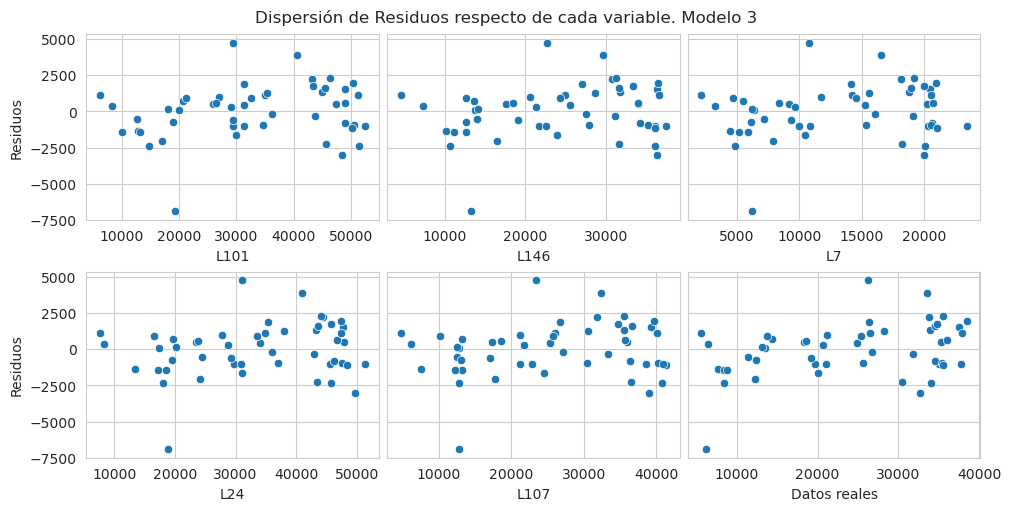

In [823]:
fig, axs = plt.subplots(2, 3, figsize = (10, 5), sharey = True, layout='constrained')

for versus, ax in zip(['L101', 'L146', 'L7', 'L24', 'L107', 'y_test'], axs.flatten()):
    sns.scatterplot(x = versus, y = "Residuos", data = test3, ax = ax)

fig.suptitle("Dispersión de Residuos respecto de cada variable. Modelo 3")
axs[1,2].set_xlabel("Datos reales")
None

No parece haber ningun tipo de estructura de los residuos respecto de ninguna variable.

In [843]:
print("Datos de test.")
print('Modelo 1:')
print(f"Raiz de ECM: {round(recm,3)}. Media de los residuos: {round(residuo_medio,2)}")
print(f"Diferencia entre media de datos reales y predichos: {abs(round(pred_mean - test_mean, 2))}")
print('Modelo 2:')
print(f"Raiz de ECM: {round(recm_2,3)}. Media de los residuos: {round(residuo2_medio,2)}")
print(f"Diferencia entre media de datos reales y predichos: {abs(round(pred2_mean - test2_mean, 2))}")
print('Modelo 3:')
print(f"Raiz de ECM: {round(recm_3,3)}. Media de los residuos: {round(residuo3_medio,2)}")
print(f"Diferencia entre media de datos reales y predichos: {abs(round(pred3_mean - test3_mean, 2))}")

Datos de test.
Modelo 1:
Raiz de ECM: 1776.885. Media de los residuos: 1306.08
Diferencia entre media de datos reales y predichos: 46.94
Modelo 2:
Raiz de ECM: 2404.49. Media de los residuos: 1875.73
Diferencia entre media de datos reales y predichos: 202.7
Modelo 3:
Raiz de ECM: 1849.925. Media de los residuos: 1402.93
Diferencia entre media de datos reales y predichos: 2.35


En conjunto con el analisis sobre los datos de test vamos a sumar un analisis sobre los datos en su totalidad. De esta manera nos aseguramos que ningun modelo tenga ninguna "particularidad" con los datos de test, asi que veamos su rendimiento.

In [866]:
X1_total = model_matrix(formula, X)
y1_total = gs.predict(X1_total)

recm1 = np.sqrt(mean_squared_error(y1_total, y))
residuo_total = (abs(y1_total - y)).mean()[0]
dif_med = (y1_total.mean()- y.mean())[0]

In [867]:
X2_total = model_matrix(formula2, X)
y2_total = gs2.predict(X2_total)

recm2 = np.sqrt(mean_squared_error(y2_total, y))
residuo_total2 = (abs(y2_total -y)).mean()[0]
dif_med2 = (y2_total.mean()-y.mean())[0]

In [868]:
X3_total = model_matrix(formula3, X)
y3_total = gs3.predict(X3_total)

recm3 = np.sqrt(mean_squared_error(y3_total, y))
residuo_total3 = (abs(y3_total -y)).mean()[0]
dif_med3 = (y3_total.mean()-y.mean())[0]

In [869]:
print("Datos de test.")
print('Modelo 1:')
print(f"Raiz de ECM: {round(recm1,3)}. Media de los residuos: {round(residuo_total,2)}")
print(f"Diferencia entre media de datos reales y predichos: {abs(round(dif_med, 2))}")
print('Modelo 2:')
print(f"Raiz de ECM: {round(recm2,3)}. Media de los residuos: {round(residuo_total2,2)}")
print(f"Diferencia entre media de datos reales y predichos: {abs(round(dif_med2, 2))}")
print('Modelo 3:')
print(f"Raiz de ECM: {round(recm3,3)}. Media de los residuos: {round(residuo_total3,2)}")
print(f"Diferencia entre media de datos reales y predichos: {abs(round(dif_med3, 2))}")

Datos de test.
Modelo 1:
Raiz de ECM: 1934.298. Media de los residuos: 1267.56
Diferencia entre media de datos reales y predichos: 8.2
Modelo 2:
Raiz de ECM: 2398.468. Media de los residuos: 1720.81
Diferencia entre media de datos reales y predichos: 50.2
Modelo 3:
Raiz de ECM: 1965.964. Media de los residuos: 1299.81
Diferencia entre media de datos reales y predichos: 3.13


Si bien son cercanos, tanto los datos de test como los totales nos dan que en raiz del error cuadratico y la media de los residuos es mejor en el primer modelo. Por lo tanto se tomara el modelo final 